Fast Fibonacci in Python
============================
The Fibonacci sequence is a classic example of a recursive relationship. It has the following definition
$$
\begin{align*}
F_n &= F_{n-1} + F_{n-2} \\
F_0 &= 0 \\
F_1 &= 1
\end{align*}
$$
There are a variety of ways to implement a function to calculate the n'th Fibonacci number.
  - **Top-down recursive**: This is one of the worst possible ways to implement Fibonacci, at least in terms of speed. This is because for each call to `fib(n)`, we make a call to `fib(n-1)` and `fib(n-2)`. For the `n-1` call we then call `fib(n-2)` and `fib(n-3)`. We've already had to calculate `fib(n-2)` twice, and this problem just gets worse the further we go down the call tree until we reach the base cases. The time complexity of this approach is $O(2^n)$ which is obviously unacceptable. This problem can be alieviated by caching already-calculated results which will help tremendously, but is still not the ideal solution.
  - **Bottom-up looping**: This is a much more reasonable solution. All we do here is start with the base cases and use the recursion rule to calculate the next 2nd Fibonacci number, then the 3rd and so on in a loop until we reach the one we are looking for. The time complexity of this solution is $O(n)$. Much better than the exponential time above, but we can still do better.
  - **Binary Matrix Exponentiation(BME)**: We can write the recursive formula as a matrix operation. To see how we do this, first consider a 2-element column vector with the elements $F_{n-1}$ and $F_{n-2}$.
  $$
  \begin{pmatrix}
  F_{n-1} \\
  F_{n-2}
  \end{pmatrix}
  $$
  We can advance this matrix to the next higher pair of Fibonacci numbers ($F_{n}$, and $F_{n-1}$) by multiplying this vector by the following matrix.
  $$
  \begin{pmatrix}
  1 & 1 \\
  1 & 0 
  \end{pmatrix}
  $$
  Finally notice that if we multiply the result by this matrix again, it advances our set of number twice, and if we start with our base case and multiply $n-1$ times, we can get the n'th Fibonacci number. Therefore, we have
  $$
  \begin{pmatrix}
  F_{n} \\
  F_{n-1}
  \end{pmatrix}
  = 
  \begin{pmatrix}
  1 & 1 \\
  1 & 0
  \end{pmatrix}^{n-1}
  \begin{pmatrix}
  1 \\
  0
  \end{pmatrix}
  $$
  Now if we can find a fast way to find the n'th power of a matrix, we would be golden. Turns out there is a fast way to do this. We just apply the [Binary Exponentiation](http://en.wikipedia.org/wiki/Exponentiation_by_squaring) algorithm which can find the n'th power of something in $O(\log(n))$ time. Since the remaining operations after we have found the power of the matrix are constant in time, the overall time complexity of our algorithm is now $O(\log(n))$. 

**NOTE:** While the BME algorithm has the best time complexity for calculating the n'th Fibonacci number, we shouldn't necessarily always use it. For small n, for example, it's likely that the simple loop algorithm will run a bit faster just because it lacks some of the extra machinery required to run BME(We'll actually see this later). Furthermore, if we are interested in calculating the Fibonacci *sequence*, meaning all of first n Fibonacci numbers, then BME has a problem because it necessarily leaps over some numbers in the sequence(hence it's speed). But this means that we would have to make a separate call to BME for each number. Turns out, this leads to $O(n\log(n))$ time complexity which is *worse* than the simple loop algorithm.

-------------------------------------------
This is all fine and good, but I wanna see some code! Okay, well since we are so hung up on doing this fast, it's probably worthwhile to make our code as efficient as possible, but we also don't want to do something crazy like not use python for once, so we're going to implement some of thise algorithms in both raw python and also using cython to get some compilation goodness. Then we will compare the speeds of the various implementations.

Ooohkay! Let's get booted up!

In [2]:
%reload_ext Cython
%load_ext watermark
%watermark -dvm -p cython,numpy,matplotlib

27/03/2015 

CPython 3.4.3
IPython 3.0.0

cython 0.22
numpy 1.9.2
matplotlib 1.4.0

compiler   : GCC 4.9.2 20150304 (prerelease)
system     : Linux
release    : 3.19.2-1-ARCH
machine    : x86_64
processor  : 
CPU cores  : 4
interpreter: 64bit


The following cell contains python implementations of the bottom-up looping and BME algorithms described above. Note I've chosen to just use an ad-hoc 2x2 matrix multiplication function rather than involve numpy. Maybe it's a bit simpler? Eh. A matter of taste.

In [2]:
def fib(n):
    a,b = 0., 1.
    for _ in range(n):
        a,b = a+b,a
    return a

E00,E01,E10,E11=0,1,2,3

tmp = [0,0,0,0]
def mat_prod(m1, m2): #m1 *= m2
    for i in range(4): tmp[i] = m1[i]
    m1[E00] = tmp[E00]*m2[E00] + tmp[E01]*m2[E10]
    m1[E01] = tmp[E00]*m2[E01] + tmp[E01]*m2[E11]
    m1[E10] = tmp[E10]*m2[E00] + tmp[E11]*m2[E10]
    m1[E11] = tmp[E10]*m2[E00] + tmp[E01]*m2[E10]

def mat_square(m1): #m1 = m1**2
    for i in range(4): tmp[i] = m1[i]
    m1[E00] = tmp[E00]*tmp[E00] + tmp[E01]*tmp[E10]
    m1[E01] = tmp[E00]*tmp[E01] + tmp[E01]*tmp[E11]
    m1[E10] = tmp[E10]*tmp[E00] + tmp[E11]*tmp[E10]
    m1[E11] = tmp[E10]*tmp[E00] + tmp[E01]*tmp[E10]

def fib_bme(n):
    x = [1.,0.,0.,1.]
    p = [1.,1.,1.,0.]
    N = 1
    while N <= n:
        if n & N:
            mat_prod(x,p)
        mat_square(p)
        N <<= 1
    return x[E10]

The cell below contains the cython implementation of the algorithms. I've tried to keep a close correspondence between the two implementations. 

In [5]:
%%cython --force

cdef float fib(int n):
    cdef int i
    cdef float a=0.0, b=1.0
    cdef float tmp
    for i in range(n):
        tmp = a
        a += b
        b = tmp
    return a

cdef unsigned int E00=0, E01=1, E10=2, E11=3

cdef float tmp[4];
cdef void mat_prod(float *m1, float *m2): # m1 *= m2
    cdef unsigned int i
    for i in range(4):
        tmp[i] = m1[i]
    m1[E00] = tmp[E00]*m2[E00] + tmp[E01]*m2[E10]
    m1[E01] = tmp[E00]*m2[E01] + tmp[E01]*m2[E11]
    m1[E10] = tmp[E10]*m2[E00] + tmp[E11]*m2[E10]
    m1[E11] = tmp[E10]*m2[E01] + tmp[E11]*m2[E11]

cdef void mat_square(float *m1): # m1*= m1
    cdef unsigned int i
    for i in range(4):
        tmp[i] = m1[i]
    m1[E00] = tmp[E00]*tmp[E00] + tmp[E01]*tmp[E10]
    m1[E01] = tmp[E00]*tmp[E01] + tmp[E01]*tmp[E11]
    m1[E10] = tmp[E10]*tmp[E00] + tmp[E11]*tmp[E10]
    m1[E11] = tmp[E10]*tmp[E01] + tmp[E11]*tmp[E11]
    
cdef float fib_bme(unsigned int n):
    cdef float *x = [1.,0.,0.,1.]
    cdef float *p = [1.,1.,1.,0.]
    cdef unsigned int N = 0x1
    while N <= n:
        if n & N:
            mat_prod(x,p) #x *= p
        mat_square(p)   #p *= p
        N <<= 1
    return x[E10]

def cfib_bme(n):
    return fib_bme(n)
def cfib(n):
    return fib(n)

Now we just run the code for a wide range of n values and see how quickly each implementation runs.

In [30]:
import time
import numpy as np
data = {fib  : [],
        cfib : [],
        fib_bme : [],
        cfib_bme : []
        }
ns = np.logspace(1,6, num=10, dtype=np.int64)[::-1]
N = 40
for n in ns:
    for func,times in data.items():
        t_start = time.time()
        for _ in range(N): 
            func(n)
        t_end = time.time()
        times.append(t_end-t_start)

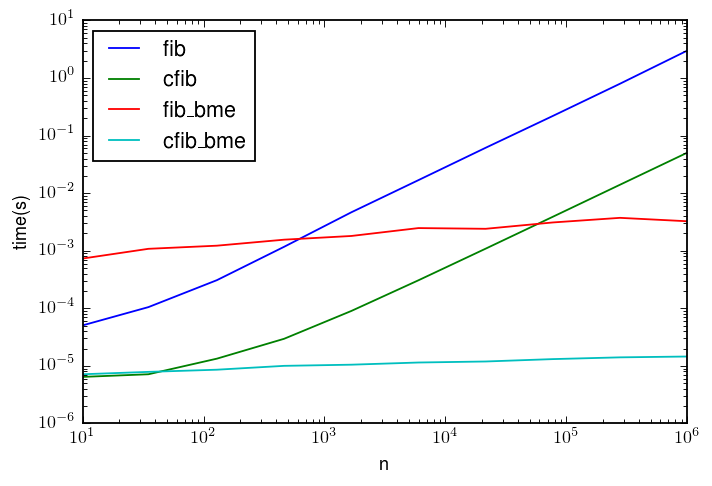

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['savefig.dpi']=130
plt.xscale('log')
plt.yscale('log')
plt.xlabel('n')
plt.ylabel('time(s)')
for func, times in data.items():
    plt.plot(ns, times, label=func.__name__.replace('_',r'\_'))
plt.legend(loc='best')
plt.show()

Conclusion
----------
There are two things to see from the graph.
  - First lets look at the pure python implementations(`fib` and `fib_bme`). For these guys, `fib` funs significantly faster for n less than a few hundred. However, for larger n, the `fib_bme` algorithm becomes much faster. 
  - Next, lets look at the cython implementations. For these there is much less drastic difference in run-times between `cfib` and `cfib_bme` than we saw with the pure python implementation. The asymptotic behaviour of the two algorithms in the cython implementation behaves the same as the python ones, as we should expect.
  - Finally, it's worth pointing out that for n greater than ~50,000, the pure python BME implementation beats out the cython looping implementation.